In [9]:
from google import genai
import os
import json
import time
import re
from PIL import Image

# Set up your Google API key
os.environ['GOOGLE_API_KEY'] = 'YOUR_GOOGLE_API_KEY_HERE' 

# Initialize the new Google AI client with thinking capabilities
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'])

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd15'
api_model_name = 'gemini-2.5-flash'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_gemini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Gemini's response for Q3 in the survey with retry mechanism
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to Q3 questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the prompt based on your Q3 question
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Generate response with thinking capabilities (new Google AI client)
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=[prompt, image],
                config=genai.types.GenerateContentConfig(
                    thinking_config=genai.types.ThinkingConfig(
                        thinking_budget=1024,  # Allow model to think before responding
                        include_thoughts=True  # Include reasoning process
                    )
                )
            )
            
            # Extract thoughts and regular response
            thoughts_text = ""
            full_response_text = ""
            
            for part in response.candidates[0].content.parts:
                if not part.text:
                    continue
                if part.thought:
                    thoughts_text += part.text + "\n"
                else:
                    full_response_text += part.text
            
            # Try to parse the response as JSON
            # Look for JSON content in the response
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'thinking_process': thoughts_text  # Include reasoning process
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Gemini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text}")
            
            # Add a small delay between retries
            time.sleep(2)
    
    # If all retries fail
    print(f"Failed to parse Gemini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'thinking_process': ""  # No thoughts if failed
    }

def extract_rating_from_text(text, question_number):
    """
    Extract rating more robustly from text using regex patterns
    
    Args:
        text: The response text to search in
        question_number: Which question (1 or 2) to look for
        
    Returns:
        Extracted rating or None if not found
    """
    # Try different regex patterns to catch various response formats
    patterns = [
        rf"{question_number}\.\s+.*?(\d+)(?:/5)?", # Matches "1. blah blah 4" or "1. blah blah 4/5"
        rf"{question_number}\.\s+.*?rating.*?(\d+)", # Matches "1. I would rate this as 4"
        rf"country_likelihood.*?:\s*(\d+)", # For JSON-like but unparseable responses
        rf"item_accuracy.*?:\s*(\d+)",
        r"(\d+)(?:/5)?\s+out of 5" # Matches "4 out of 5" or "4/5 out of 5"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if match:
            try:
                rating = int(match.group(1))
                return min(max(rating, 1), 5)  # Ensure rating is between 1-5
            except (ValueError, IndexError):
                continue
    
    return None



def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items(survey_list):
    """
    Process all survey items and add Gemini responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Gemini responses
    """
    # For storing raw Gemini responses
    raw_gemini_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Gemini responses (multiple possible field names)
            if ('gemini_responses' in survey_data and survey_data['gemini_responses'] is not None) or \
               ('Q3_country_likelihood' in survey_data and survey_data['Q3_country_likelihood'] is not None) or \
               ('Q3_item_accuracy' in survey_data and survey_data['Q3_item_accuracy'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Q3 Gemini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with model {model_name} for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Gemini's response
                item_name_clean = item_name.replace("_", " ")
                gemini_data = get_gemini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_gemini_responses[f"{model_name}-{item_name}"] = gemini_data['full_response']
                
                # If we got a valid parsed result, use it
                if gemini_data['parsed_result']:
                    result = gemini_data['parsed_result']
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': result['country_likelihood'],
                        'Q3_item_accuracy': result['item_accuracy'],
                        'Q3a_details': result['details_analysis']
                    }
                else:
                    # Try to extract ratings from the text as a fallback
                    country_rating = extract_rating_from_text(gemini_data['full_response'], 1)
                    item_rating = extract_rating_from_text(gemini_data['full_response'], 2)
                    
                    # If we still couldn't extract ratings, report failure
                    if country_rating is None or item_rating is None:
                        print(f"Could not extract ratings for {item_name}, marking as failed")
                        failed_items.append({
                            'item': item_name,
                            'model': model_name,
                            'reason': 'Failed to extract ratings',
                            'response': gemini_data['full_response']
                        })
                        continue
                    
                    # Extract details - take everything after "3."
                    details_text = ""
                    matches = re.split(r'3\.\s+', gemini_data['full_response'])
                    if len(matches) > 1:
                        details_text = matches[1].strip()
                    else:
                        # Alternative: look for details_analysis in response
                        details_match = re.search(r'details_analysis["\']?\s*:\s*["\']?(.*?)["\']?(?:,|\})', 
                                                gemini_data['full_response'], re.DOTALL)
                        if details_match:
                            details_text = details_match.group(1).strip()
                        else:
                            # Last resort: use full response
                            details_text = gemini_data['full_response']
                    
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': country_rating,
                        'Q3_item_accuracy': item_rating,
                        'Q3a_details': details_text
                    }
                
                # Save progress after each item (standardized directory structure)
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data with unique naming for Q3 responses
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-q3-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw Gemini responses separately with unique naming
                with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses.json'), 'w') as f:
                    json.dump(raw_gemini_responses, f, indent=4)
                    
                # Save list of failed items with unique naming
                with open(os.path.join(output_dir, f'failed-items-q3-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                print(f"Successfully processed {item_name}")
                
                # Add a delay to avoid API rate limits
                time.sleep(2)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_gemini_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Gemini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items...")
    updated_surveys, raw_responses, failed_items = process_survey_items(survey_list)
    
    # Save the final results (standardized directory structure)
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data with unique naming for final Q3 responses
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-q3-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw Gemini responses separately with unique naming
    with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items with unique naming
    with open(os.path.join(output_dir, f'failed-items-q3-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")

Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd15-with-sid.json
Starting to process 300 items...
Processing Gallo_pinto (rice_dish) with model sd15 for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd15-Gallo_pinto-van.png
Successfully processed Gallo_pinto
Processing Arroz_chaufa (rice_dish) with model sd15 for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd15-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa
Processing Panta_Bhat (rice_dish) with model sd15 for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd15-Panta_Bhat-van.png
Successfully processed Panta_Bhat
Processing Omurice (rice_dish) with model sd15 for region Japan...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Omurice/sd15-Omurice-van.png
Successfully processed Omurice
Processing Pabellón_criollo (rice_dish) with model

In [1]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-a.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "o4-mini"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'o4mini'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_o4mini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ],
                reasoning_effort="high"  # High reasoning effort for thorough analysis
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_o4mini(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure o4-mini responses
            if ('azure_o4mini_responses' in survey_data and survey_data['azure_o4mini_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_o4mini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-o4mini-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_o4mini_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_o4mini(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-flux-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Gallo_pinto (rice_dish) with Azure o4-mini for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/flux-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 1, Reasoning tokens: 448
Processing Arroz_chaufa (rice_dish) with Azure o4-mini for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/flux-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 320
Processing Panta_Bhat (rice_dish) with Azure o4-mini for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/flux-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 4, Accuracy: 1, Reasoning tokens: 576
Processing Omurice (rice_dish) with Azure o4-mini for region Japa

In [ ]:
from google import genai
import os
import json
import time
import re
from PIL import Image

# Set up your Google API key 
os.environ['GOOGLE_API_KEY'] =  'YOUR_GOOGLE_API_KEY_HERE'

# Initialize the new Google AI client with thinking capabilities
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'])

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd15'
api_model_name = 'gemini-2.5-flash'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_gemini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Gemini's response for Q3 in the survey with retry mechanism
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to Q3 questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the prompt based on your Q3 question
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Generate response with thinking capabilities (new Google AI client)
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=[prompt, image],
                config=genai.types.GenerateContentConfig(
                    thinking_config=genai.types.ThinkingConfig(
                        thinking_budget=1024,  # Allow model to think before responding
                        include_thoughts=True  # Include reasoning process
                    )
                )
            )
            
            # Add debug information
            print(f"Response object: {response}")
            if response and response.candidates:
                print(f"Number of candidates: {len(response.candidates)}")
                print(f"First candidate: {response.candidates[0]}")
                if response.candidates[0].content:
                    print(f"Content: {response.candidates[0].content}")
                    if response.candidates[0].content.parts:
                        print(f"Number of parts: {len(response.candidates[0].content.parts)}")
            
            # Check if response is valid before accessing
            if not response or not response.candidates or not response.candidates[0].content or not response.candidates[0].content.parts:
                raise Exception("Empty or invalid response from Gemini API")
            
            # Extract thoughts and regular response
            thoughts_text = ""
            full_response_text = ""
            
            for part in response.candidates[0].content.parts:
                if not part.text:
                    continue
                if part.thought:
                    thoughts_text += part.text + "\n"
                else:
                    full_response_text += part.text
            
            # Try to parse the response as JSON
            # Look for JSON content in the response
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'thinking_process': thoughts_text  # Include reasoning process
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Gemini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text}")
            
            # Add a small delay between retries
            time.sleep(2)
    
    # If all retries fail
    print(f"Failed to parse Gemini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text,
        'thinking_process': ""  # No thoughts if failed
    }

def extract_rating_from_text(text, question_number):
    """
    Extract rating more robustly from text using regex patterns
    
    Args:
        text: The response text to search in
        question_number: Which question (1 or 2) to look for
        
    Returns:
        Extracted rating or None if not found
    """
    # Try different regex patterns to catch various response formats
    patterns = [
        rf"{question_number}\.\s+.*?(\d+)(?:/5)?", # Matches "1. blah blah 4" or "1. blah blah 4/5"
        rf"{question_number}\.\s+.*?rating.*?(\d+)", # Matches "1. I would rate this as 4"
        rf"country_likelihood.*?:\s*(\d+)", # For JSON-like but unparseable responses
        rf"item_accuracy.*?:\s*(\d+)",
        r"(\d+)(?:/5)?\s+out of 5" # Matches "4 out of 5" or "4/5 out of 5"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if match:
            try:
                rating = int(match.group(1))
                return min(max(rating, 1), 5)  # Ensure rating is between 1-5
            except (ValueError, IndexError):
                continue
    
    return None



def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items(survey_list):
    """
    Process all survey items and add Gemini responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Gemini responses
    """
    # For storing raw Gemini responses
    raw_gemini_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Filter to only process specific items
            if survey_data.get('Item') not in ['Ba_tầm', 'Buddhas_of_Bamiyan', 'Mother_Ukraine', 'Singing_boy_with_a_flute', 'A_Ride_for_Liberty', 'Badshahi_Masjid']:
                continue
                
            # Check if survey already has Gemini responses (multiple possible field names)
            if ('gemini_responses' in survey_data and survey_data['gemini_responses'] is not None) or \
               ('Q3_country_likelihood' in survey_data and survey_data['Q3_country_likelihood'] is not None) or \
               ('Q3_item_accuracy' in survey_data and survey_data['Q3_item_accuracy'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Q3 Gemini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with model {model_name} for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Gemini's response
                item_name_clean = item_name.replace("_", " ")
                gemini_data = get_gemini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_gemini_responses[f"{model_name}-{item_name}"] = gemini_data['full_response']
                
                # If we got a valid parsed result, use it
                if gemini_data['parsed_result']:
                    result = gemini_data['parsed_result']
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': result['country_likelihood'],
                        'Q3_item_accuracy': result['item_accuracy'],
                        'Q3a_details': result['details_analysis']
                    }
                else:
                    # Try to extract ratings from the text as a fallback
                    country_rating = extract_rating_from_text(gemini_data['full_response'], 1)
                    item_rating = extract_rating_from_text(gemini_data['full_response'], 2)
                    
                    # If we still couldn't extract ratings, report failure
                    if country_rating is None or item_rating is None:
                        print(f"Could not extract ratings for {item_name}, marking as failed")
                        failed_items.append({
                            'item': item_name,
                            'model': model_name,
                            'reason': 'Failed to extract ratings',
                            'response': gemini_data['full_response']
                        })
                        continue
                    
                    # Extract details - take everything after "3."
                    details_text = ""
                    matches = re.split(r'3\.\s+', gemini_data['full_response'])
                    if len(matches) > 1:
                        details_text = matches[1].strip()
                    else:
                        # Alternative: look for details_analysis in response
                        details_match = re.search(r'details_analysis["\']?\s*:\s*["\']?(.*?)["\']?(?:,|\})', 
                                                gemini_data['full_response'], re.DOTALL)
                        if details_match:
                            details_text = details_match.group(1).strip()
                        else:
                            # Last resort: use full response
                            details_text = gemini_data['full_response']
                    
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': country_rating,
                        'Q3_item_accuracy': item_rating,
                        'Q3a_details': details_text
                    }
                
                # Save progress after each item (standardized directory structure)
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data with unique naming for Q3 responses (Venus_de_Milo specific)
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-q3-responses-retry.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw Gemini responses separately with unique naming (Venus_de_Milo specific)
                with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses-retry.json'), 'w') as f:
                    json.dump(raw_gemini_responses, f, indent=4)
                    
                # Save list of failed items with unique naming (Venus_de_Milo specific)
                with open(os.path.join(output_dir, f'failed-items-q3-{model_name}-retry.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                print(f"Successfully processed {item_name}")
                
                # Add a delay to avoid API rate limits
                time.sleep(2)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_gemini_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Gemini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items...")
    updated_surveys, raw_responses, failed_items = process_survey_items(survey_list)
    
    # Save the final results (standardized directory structure)
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data with unique naming for final Q3 responses (Venus_de_Milo specific)
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-q3-responses-retry-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw Gemini responses separately with unique naming (Venus_de_Milo specific)
    with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses-retry-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items with unique naming (Venus_de_Milo specific)
    with open(os.path.join(output_dir, f'failed-items-q3-{model_name}-retry-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")

Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd15-with-sid.json
Starting to process 300 items...
Processing Ba_tầm (hat) with model sd15 for region Vietnam...
Found image at: /home/mahesh/user_study_img_exp/Fashion/Hat/Ba_tầm/sd15-Ba_tầm-van.png
Response object: candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=True, inline_data=None, file_data=None, thought_signature=None, code_execution_result=None, executable_code=None, function_call=None, function_response=None, text='**My Analysis of the AI-Generated Image**\n\nOkay, so I\'m presented with an AI-generated image that\'s *supposed* to depict a "Ba tầm" hat. The user wants me to assess it, and my initial thought is, "Where\'s the hat?" The image description is fundamentally flawed because what I\'m seeing is a group of people, possibly in Vietnam judging by the context, but absolutely *no* hats, and certainly no Ba tầm hats. This is a major disconnect.\n\nLet\'s break d

In [4]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-a.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "o4-mini"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'o4mini'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_o4mini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ],
                reasoning_effort="high"  # High reasoning effort for thorough analysis
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_o4mini(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
            if survey_data.get('Item') not in ['Namysto', 'Pen\u00e9lope_Cruz', 'Buergbrennen', 'Anastasis_fresco']:
                continue    
            # Check if survey already has Azure o4-mini responses
            if ('azure_o4mini_responses' in survey_data and survey_data['azure_o4mini_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_o4mini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-o4mini-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_o4mini_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_o4mini(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL_retry.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL_retry.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL_retry.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-flux-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Namysto (jewellery) with Azure o4-mini for region Ukraine...
Found image at: /home/mahesh/user_study_img_exp/Fashion/Jewellery/Namysto/flux-Namysto-van.png
API Error on attempt 1: Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'jailbreak': {'filtered': True, 'detected': True}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}
API Error on attempt 2: Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'jailbreak': 

In [5]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-a.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "o4-mini"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd35'
api_model_name = 'o4mini'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_o4mini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ],
                reasoning_effort="high"  # High reasoning effort for thorough analysis
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_o4mini(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure o4-mini responses
            if ('azure_o4mini_responses' in survey_data and survey_data['azure_o4mini_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_o4mini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-o4mini-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_o4mini_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_o4mini(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd35-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Gallo_pinto (rice_dish) with Azure o4-mini for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd35-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 3, Reasoning tokens: 448
Processing Arroz_chaufa (rice_dish) with Azure o4-mini for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd35-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 320
Processing Panta_Bhat (rice_dish) with Azure o4-mini for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd35-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 5, Accuracy: 1, Reasoning tokens: 448
Processing Omurice (rice_dish) with Azure o4-mini for region Japa

In [1]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-a.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "o4-mini"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd15'
api_model_name = 'o4mini'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_o4mini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ],
                reasoning_effort="high"  # High reasoning effort for thorough analysis
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_o4mini(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure o4-mini responses
            if ('azure_o4mini_responses' in survey_data and survey_data['azure_o4mini_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_o4mini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-o4mini-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_o4mini_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_o4mini(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd15-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Gallo_pinto (rice_dish) with Azure o4-mini for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd15-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 1, Reasoning tokens: 512
Processing Arroz_chaufa (rice_dish) with Azure o4-mini for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd15-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 512
Processing Panta_Bhat (rice_dish) with Azure o4-mini for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd15-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 5, Accuracy: 1, Reasoning tokens: 448
Processing Omurice (rice_dish) with Azure o4-mini for region Japa

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-b.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4.1"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'gpt-4.1'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4_1_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4_1(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure o4-mini responses
            if ('azure_gpt4_1_responses' in survey_data and survey_data['azure_gpt4_1_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4_1_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4_1-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4_1_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4_1(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-flux-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Gallo_pinto (rice_dish) with Azure o4-mini for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/flux-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure o4-mini for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/flux-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure o4-mini for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/flux-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 1, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure o4-mini for region Japan...
F

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for o4-mini
AZURE_OPENAI_ENDPOINT = "https://waiv-west-us-b.openai.azure.com/"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4.1"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd35'
api_model_name = 'gpt-4.1'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4_1_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI o4-mini's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with o4-mini - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-o4-mini'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure o4-mini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure o4-mini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-o4-mini'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4_1(survey_list):
    """
    Process all survey items with Azure OpenAI o4-mini and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure o4-mini responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure o4-mini responses
            if ('azure_gpt4_1_responses' in survey_data and survey_data['azure_gpt4_1_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure o4-mini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure o4-mini for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure o4-mini's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4_1_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4_1-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4_1_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure o4-mini response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure o4-mini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure o4-mini...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4_1(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd35-with-sid.json
Starting to process 300 items with Azure o4-mini...
Processing Gallo_pinto (rice_dish) with Azure o4-mini for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd35-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 3, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure o4-mini for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd35-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 3, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure o4-mini for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd35-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 5, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure o4-mini for region Japan...
F

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for gpt-4.1
AZURE_OPENAI_ENDPOINT = "https://waiv-east-us-4.openai.azure.com"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4o"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'gpt-4o'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4_1_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI gpt-4o's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with gpt-4.1 - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-gpt-4.1'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure gpt-4.1 response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure gpt-4.1 response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-gpt-4.1'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4_1(survey_list):
    """
    Process all survey items with Azure OpenAI gpt-4.1 and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure gpt-4.1 responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure gpt-4.1 responses
            if ('azure_gpt4_1_responses' in survey_data and survey_data['azure_gpt4_1_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure gpt-4.1 responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure gpt-4.1 for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure gpt-4.1's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4_1_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4_1-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4_1_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure gpt-4.1 response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure gpt-4.1
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure gpt-4.1...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4_1(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd15-with-sid.json
Starting to process 300 items with Azure gpt-4.1...
Processing Gallo_pinto (rice_dish) with Azure gpt-4.1 for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd15-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure gpt-4.1 for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd15-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure gpt-4.1 for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd15-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 5, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure gpt-4.1 for region Japan...
F

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for gpt-4o
AZURE_OPENAI_ENDPOINT = "https://waiv-east-us-4.openai.azure.com"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4o"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'gpt-4o'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4o_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI gpt-4o's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with gpt-4o - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-gpt-4o'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure gpt-4o response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure gpt-4o response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-gpt-4o'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4o(survey_list):
    """
    Process all survey items with Azure OpenAI gpt-4o and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure gpt-4o responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure gpt-4o responses
            if ('azure_gpt4o_responses' in survey_data and survey_data['azure_gpt4o_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure gpt-4o responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure gpt-4o for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure gpt-4o's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4o_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4o-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4o_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure gpt-4o response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure gpt-4o
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure gpt-4o...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4o(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-flux-with-sid.json
Starting to process 300 items with Azure gpt-4o...
Processing Gallo_pinto (rice_dish) with Azure gpt-4o for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/flux-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure gpt-4o for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/flux-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure gpt-4o for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/flux-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 1, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure gpt-4o for region Japan...
Found 

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for gpt-4o
AZURE_OPENAI_ENDPOINT = "https://waiv-east-us-5.openai.azure.com"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4o"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd35'
api_model_name = 'gpt-4o'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4o_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI gpt-4o's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with gpt-4o - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-gpt-4o'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure gpt-4o response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure gpt-4o response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-gpt-4o'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4o(survey_list):
    """
    Process all survey items with Azure OpenAI gpt-4o and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure gpt-4o responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure gpt-4o responses
            if ('azure_gpt4o_responses' in survey_data and survey_data['azure_gpt4o_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure gpt-4o responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure gpt-4o for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure gpt-4o's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4o_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4o-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4o_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure gpt-4o response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure gpt-4o
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure gpt-4o...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4o(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd35-with-sid.json
Starting to process 300 items with Azure gpt-4o...
Processing Gallo_pinto (rice_dish) with Azure gpt-4o for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd35-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 4, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure gpt-4o for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd35-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 3, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure gpt-4o for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd35-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 1, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure gpt-4o for region Japan...
Found 

In [ ]:
from openai import AzureOpenAI
import os
import json
import time
import re
from PIL import Image

# Azure OpenAI configuration for gpt-4o
AZURE_OPENAI_ENDPOINT = "https://waiv-east-us-5.openai.azure.com"
AZURE_OPENAI_API_KEY = "YOUR_AZURE_OPENAI_API_KEY_HERE"
AZURE_API_VERSION = "2025-01-01-preview"
AZURE_MODEL_NAME = "gpt-4o"

# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_API_VERSION
)

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'sd15'
api_model_name = 'gpt-4o'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_azure_gpt4o_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Azure OpenAI gpt-4o's response - using identical prompt as Gemini for fair comparison
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to evaluation questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the EXACT SAME prompt as Gemini for fair comparison
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.
        """
        
        try:
            # Convert PIL image to base64 for Azure OpenAI
            import base64
            import io
            
            # Convert image to bytes
            img_byte_arr = io.BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()
            
            # Encode to base64
            img_base64 = base64.b64encode(img_byte_arr).decode('utf-8')
            
            # Generate response with gpt-4o - NO SYSTEM MESSAGE
            response = azure_client.chat.completions.create(
                model=AZURE_MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{img_base64}"
                                }
                            }
                        ]
                    }
                ]
            )
            
            # Extract the response content
            full_response_text = response.choices[0].message.content
            
            # Extract reasoning tokens usage if available
            reasoning_tokens = 0
            if hasattr(response, 'usage') and hasattr(response.usage, 'completion_tokens_details'):
                if hasattr(response.usage.completion_tokens_details, 'reasoning_tokens'):
                    reasoning_tokens = response.usage.completion_tokens_details.reasoning_tokens
            
            # Try to parse the response as JSON
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_match = re.search(r'\{[^{}]*"country_likelihood"[^{}]*\}', full_response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'reasoning_tokens': reasoning_tokens,
                'model_used': 'azure-gpt-4o'
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Azure gpt-4o response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text[:500]}...")
            
            # Add a small delay between retries
            time.sleep(2)
        
        except Exception as e:
            print(f"API Error on attempt {attempt + 1}: {str(e)}")
            time.sleep(3)
    
    # If all retries fail
    print(f"Failed to parse Azure gpt-4o response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'reasoning_tokens': 0,
        'model_used': 'azure-gpt-4o'
    }

def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items_azure_gpt4o(survey_list):
    """
    Process all survey items with Azure OpenAI gpt-4o and add responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Azure gpt-4o responses
    """
    # For storing raw responses
    raw_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Azure gpt-4o responses
            if ('azure_gpt4o_responses' in survey_data and survey_data['azure_gpt4o_responses'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Azure gpt-4o responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with Azure gpt-4o for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Azure gpt-4o's response
                item_name_clean = item_name.replace("_", " ")
                azure_data = get_azure_gpt4o_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_responses[f"azure-gpt4o-{model_name}-{item_name}"] = azure_data['full_response']
                
                # If we got a valid parsed result, use it
                if azure_data['parsed_result']:
                    result = azure_data['parsed_result']
                    survey_data['azure_gpt4o_responses'] = {
                        'country_likelihood': result['country_likelihood'],
                        'item_accuracy': result['item_accuracy'],
                        'details_analysis': result['details_analysis'],
                        'reasoning_tokens': azure_data['reasoning_tokens'],
                        'model_used': azure_data['model_used']
                    }
                    print(f"Successfully processed {item_name} - Country: {result['country_likelihood']}, Accuracy: {result['item_accuracy']}, Reasoning tokens: {azure_data['reasoning_tokens']}")
                else:
                    print(f"Failed to parse Azure gpt-4o response for {item_name}")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Failed to parse response',
                        'response': azure_data['full_response'][:500]
                    })
                    continue
                
                # Save progress after each item
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw responses
                with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses.json'), 'w') as f:
                    json.dump(raw_responses, f, indent=4)
                    
                # Save list of failed items
                with open(os.path.join(output_dir, f'failed-items-cure-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                # Add a delay to avoid API rate limits
                time.sleep(3)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Azure gpt-4o
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items with Azure gpt-4o...")
    updated_surveys, raw_responses, failed_items = process_survey_items_azure_gpt4o(survey_list)
    
    # Save the final results
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw responses
    with open(os.path.join(output_dir, f'raw-{api_model_name}-cure-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items
    with open(os.path.join(output_dir, f'failed-items-cure-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")


Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-sd15-with-sid.json
Starting to process 300 items with Azure gpt-4o...
Processing Gallo_pinto (rice_dish) with Azure gpt-4o for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/sd15-Gallo_pinto-van.png
Successfully processed Gallo_pinto - Country: 5, Accuracy: 2, Reasoning tokens: 0
Processing Arroz_chaufa (rice_dish) with Azure gpt-4o for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/sd15-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa - Country: 5, Accuracy: 3, Reasoning tokens: 0
Processing Panta_Bhat (rice_dish) with Azure gpt-4o for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/sd15-Panta_Bhat-van.png
Successfully processed Panta_Bhat - Country: 1, Accuracy: 1, Reasoning tokens: 0
Processing Omurice (rice_dish) with Azure gpt-4o for region Japan...
Found 

In [1]:
from google import genai
import os
import json
import time
import re
from PIL import Image

# Set up your Google API key
os.environ['GOOGLE_API_KEY'] = 'YOUR_GOOGLE_API_KEY_HERE' 

# Initialize the new Google AI client with thinking capabilities
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'])

# Base directory for your images
BASE_DIR = '/home/mahesh/user_study_img_exp/'
model_name = 'flux'
api_model_name = 'gemini-2.5-flash'
# Path to your existing survey JSON file
SURVEY_JSON_PATH = f'/home/mahesh/git1/gerafe/user_study/json/output-{model_name}-with-sid.json'

def load_image_from_path(image_path):
    """Load a local image file"""
    try:
        return Image.open(image_path)
    except Exception as e:
        raise Exception(f"Failed to load image: {str(e)}")

def get_gemini_response(image, item_name, category_name, country="United States", max_retries=3):
    """
    Get Gemini's response for Q3 in the survey with retry mechanism
    
    Args:
        image: The PIL Image object
        item_name: Name of the item (e.g., "Brooklyn Bridge")
        category_name: Category of the item (e.g., "bridge")
        country: Country for cultural context (default is "United States")
        max_retries: Maximum number of retry attempts
        
    Returns:
        Dictionary with responses to Q3 questions and the full response text
    """
    for attempt in range(max_retries):
        # Create the prompt based on your Q3 question
        prompt = f"""
        This is an AI-generated image of {item_name}, which is a type of {category_name}.

        IMPORTANT: Base your responses ONLY on what you can observe in the image itself. Do NOT use your prior knowledge about the item name or its typical association with the country and give your rating accordingly.
        
        Please analyze this image and answer the following questions:
        
        1. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           based solely on the visual elements, architectural style, cultural markers, and other observable features in this image,
           how likely can this item be found in {country}?
        
        2. On a scale of 1-5 (where 1 is "Highly Unlikely" and 5 is "Extremely Likely"), 
           how likely is this an accurate image of {item_name}?
        
        3. What specific details in the AI-generated image make it accurate or inaccurate 
           compared to how this object typically appears in {country} or your understanding of {item_name}?
           
        Format your response as JSON with keys: 'country_likelihood', 'item_accuracy', and 'details_analysis'.

        """
        
        try:
            # Generate response with thinking capabilities (new Google AI client)
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=[prompt, image],
                config=genai.types.GenerateContentConfig(
                    thinking_config=genai.types.ThinkingConfig(
                        thinking_budget=1024,  # Allow model to think before responding
                        include_thoughts=True  # Include reasoning process
                    )
                )
            )
            
            # Extract thoughts and regular response
            thoughts_text = ""
            full_response_text = ""
            
            for part in response.candidates[0].content.parts:
                if not part.text:
                    continue
                if part.thought:
                    thoughts_text += part.text + "\n"
                else:
                    full_response_text += part.text
            
            # Try to parse the response as JSON
            # Look for JSON content in the response
            json_match = re.search(r'```json\n(.*?)\n```', full_response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON-like content without the markdown tags
                json_str = full_response_text
                
            # Clean up the string to ensure it's valid JSON
            json_str = json_str.replace('```', '').strip()
            result = json.loads(json_str)
            
            # Validate expected fields exist
            required_fields = ['country_likelihood', 'item_accuracy', 'details_analysis']
            for field in required_fields:
                if field not in result:
                    raise KeyError(f"Missing required field: {field}")
                    
            # Ensure ratings are integers between 1-5
            if not isinstance(result['country_likelihood'], int) or not (1 <= result['country_likelihood'] <= 5):
                raise ValueError(f"Invalid country_likelihood value: {result['country_likelihood']}")
                
            if not isinstance(result['item_accuracy'], int) or not (1 <= result['item_accuracy'] <= 5):
                raise ValueError(f"Invalid item_accuracy value: {result['item_accuracy']}")
            
            return {
                'parsed_result': result,
                'full_response': full_response_text,
                'thinking_process': thoughts_text  # Include reasoning process
            }
            
        except (json.JSONDecodeError, KeyError, ValueError) as e:
            print(f"Error parsing Gemini response on attempt {attempt + 1}: {str(e)}")
            print(f"Full response text: {full_response_text}")
            
            # Add a small delay between retries
            time.sleep(2)
    
    # If all retries fail
    print(f"Failed to parse Gemini response after {max_retries} attempts")
    return {
        'parsed_result': None,
        'full_response': full_response_text if 'full_response_text' in locals() else "",
        'thinking_process': ""  # No thoughts if failed
    }

def extract_rating_from_text(text, question_number):
    """
    Extract rating more robustly from text using regex patterns
    
    Args:
        text: The response text to search in
        question_number: Which question (1 or 2) to look for
        
    Returns:
        Extracted rating or None if not found
    """
    # Try different regex patterns to catch various response formats
    patterns = [
        rf"{question_number}\.\s+.*?(\d+)(?:/5)?", # Matches "1. blah blah 4" or "1. blah blah 4/5"
        rf"{question_number}\.\s+.*?rating.*?(\d+)", # Matches "1. I would rate this as 4"
        rf"country_likelihood.*?:\s*(\d+)", # For JSON-like but unparseable responses
        rf"item_accuracy.*?:\s*(\d+)",
        r"(\d+)(?:/5)?\s+out of 5" # Matches "4 out of 5" or "4/5 out of 5"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if match:
            try:
                rating = int(match.group(1))
                return min(max(rating, 1), 5)  # Ensure rating is between 1-5
            except (ValueError, IndexError):
                continue
    
    return None



def find_item_filepath(item_name, model_name):
    """
    Search for an item's directory and vanilla image file in the file structure
    
    Args:
        item_name: Name of the item (e.g., "Brooklyn_Bridge")
        model_name: Model name (e.g., "flux")
        
    Returns:
        Tuple of (main_category, sub_category, image_path) if found, or (None, None, None) if not found
    """
    # Main categories (Architecture, Art, etc.)
    main_categories = [d for d in os.listdir(BASE_DIR) 
                      if os.path.isdir(os.path.join(BASE_DIR, d)) 
                      and not d.startswith('_') 
                      and not d.startswith('.')]
    
    for main_category in main_categories:
        if main_category not in ['Architecture', 'Art', 'Celebrations', 'Fashion', 'Food', 'People']:
            continue
            
        main_path = os.path.join(BASE_DIR, main_category)
        
        # Sub-categories (Bridge, House, etc.)
        sub_categories = [d for d in os.listdir(main_path) 
                         if os.path.isdir(os.path.join(main_path, d))]
        
        for sub_category in sub_categories:
            sub_path = os.path.join(main_path, sub_category)
            
            # Check if this sub_category contains our item
            item_path = os.path.join(sub_path, item_name)
            
            if os.path.isdir(item_path):
                # Found the item directory, now look for the vanilla image
                vanilla_image = f"{model_name}-{item_name}-van.png"
                image_path = os.path.join(item_path, vanilla_image)
                
                if os.path.isfile(image_path):
                    return main_category, sub_category, image_path
    
    return None, None, None

def process_survey_items(survey_list):
    """
    Process all survey items and add Gemini responses
    
    Args:
        survey_list: The survey list JSON data from your existing JSON file
        
    Returns:
        Updated survey list with Gemini responses
    """
    # For storing raw Gemini responses
    raw_gemini_responses = {}
    failed_items = []
    
    # Process each survey category and items
    for category_name, items in survey_list.items():
        if not isinstance(items, list): 
            continue
            
        for i, survey_data in enumerate(items):
            if not isinstance(survey_data, dict):
                continue
                
            # Check if survey already has Gemini responses (multiple possible field names)
            if ('gemini_responses' in survey_data and survey_data['gemini_responses'] is not None) or \
               ('Q3_country_likelihood' in survey_data and survey_data['Q3_country_likelihood'] is not None) or \
               ('Q3_item_accuracy' in survey_data and survey_data['Q3_item_accuracy'] is not None):
                print(f"Survey for {survey_data.get('Item', 'Unknown')} already has Q3 Gemini responses, skipping!")
                continue
                
            try:
                # Get item details
                item_name = survey_data['Item']
                item_category = survey_data['Category'].lower()
                country = survey_data.get('Region', 'General')
                
                print(f"Processing {item_name} ({item_category}) with model {model_name} for region {country}...")
                
                # Find the image file path
                main_category, sub_category, image_path = find_item_filepath(item_name, model_name)
                
                if not image_path:
                    print(f"Could not find image for {item_name} with model {model_name}, skipping.")
                    failed_items.append({
                        'item': item_name,
                        'model': model_name,
                        'reason': 'Image not found'
                    })
                    continue
                
                print(f"Found image at: {image_path}")
                
                # Load the image
                image = load_image_from_path(image_path)
                
                # Get Gemini's response
                item_name_clean = item_name.replace("_", " ")
                gemini_data = get_gemini_response(image, item_name_clean, item_category, country)
                
                # Store the raw response
                raw_gemini_responses[f"{model_name}-{item_name}"] = gemini_data['full_response']
                
                # If we got a valid parsed result, use it
                if gemini_data['parsed_result']:
                    result = gemini_data['parsed_result']
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': result['country_likelihood'],
                        'Q3_item_accuracy': result['item_accuracy'],
                        'Q3a_details': result['details_analysis']
                    }
                else:
                    # Try to extract ratings from the text as a fallback
                    country_rating = extract_rating_from_text(gemini_data['full_response'], 1)
                    item_rating = extract_rating_from_text(gemini_data['full_response'], 2)
                    
                    # If we still couldn't extract ratings, report failure
                    if country_rating is None or item_rating is None:
                        print(f"Could not extract ratings for {item_name}, marking as failed")
                        failed_items.append({
                            'item': item_name,
                            'model': model_name,
                            'reason': 'Failed to extract ratings',
                            'response': gemini_data['full_response']
                        })
                        continue
                    
                    # Extract details - take everything after "3."
                    details_text = ""
                    matches = re.split(r'3\.\s+', gemini_data['full_response'])
                    if len(matches) > 1:
                        details_text = matches[1].strip()
                    else:
                        # Alternative: look for details_analysis in response
                        details_match = re.search(r'details_analysis["\']?\s*:\s*["\']?(.*?)["\']?(?:,|\})', 
                                                gemini_data['full_response'], re.DOTALL)
                        if details_match:
                            details_text = details_match.group(1).strip()
                        else:
                            # Last resort: use full response
                            details_text = gemini_data['full_response']
                    
                    survey_data['gemini_responses'] = {
                        'Q3_country_likelihood': country_rating,
                        'Q3_item_accuracy': item_rating,
                        'Q3a_details': details_text
                    }
                
                # Save progress after each item (standardized directory structure)
                output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
                os.makedirs(output_dir, exist_ok=True)
                
                # Save main survey data with unique naming for Q3 responses
                with open(os.path.join(output_dir, f'output-{model_name}-with-{api_model_name}-q3-responses.json'), 'w') as f:
                    json.dump(survey_list, f, indent=4)
                
                # Save raw Gemini responses separately with unique naming
                with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses.json'), 'w') as f:
                    json.dump(raw_gemini_responses, f, indent=4)
                    
                # Save list of failed items with unique naming
                with open(os.path.join(output_dir, f'failed-items-q3-{model_name}.json'), 'w') as f:
                    json.dump(failed_items, f, indent=4)
                    
                print(f"Successfully processed {item_name}")
                
                # Add a delay to avoid API rate limits
                time.sleep(2)
                
            except Exception as e:
                print(f"Error processing {survey_data.get('Item', 'unknown')}: {str(e)}")
                failed_items.append({
                    'item': survey_data.get('Item', 'unknown'),
                    'model': survey_data.get('Model-Name', 'unknown'),
                    'reason': str(e)
                })
                continue
        
    return survey_list, raw_gemini_responses, failed_items

# Example usage:
if __name__ == "__main__":
    # Load your existing survey data
    try:
        with open(SURVEY_JSON_PATH, 'r') as f:
            survey_list = json.load(f)
        print(f"Loaded existing survey data from {SURVEY_JSON_PATH}")
    except Exception as e:
        print(f"Error loading survey data: {str(e)}")
        exit(1)
    
    # Process all surveys with Gemini
    print(f"Starting to process {sum(len(items) for items in survey_list.values())} items...")
    updated_surveys, raw_responses, failed_items = process_survey_items(survey_list)
    
    # Save the final results (standardized directory structure)
    output_dir = os.path.join(BASE_DIR, f'results_{model_name}_{api_model_name}')
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main survey data with unique naming for final Q3 responses
    with open(os.path.join(output_dir, f'output-all-with-{api_model_name}-q3-responses-FINAL.json'), 'w') as f:
        json.dump(updated_surveys, f, indent=4)
    
    # Save raw Gemini responses separately with unique naming
    with open(os.path.join(output_dir, f'raw-{api_model_name}-q3-responses-FINAL.json'), 'w') as f:
        json.dump(raw_responses, f, indent=4)
        
    # Save list of failed items with unique naming
    with open(os.path.join(output_dir, f'failed-items-q3-{model_name}-FINAL.json'), 'w') as f:
        json.dump(failed_items, f, indent=4)
    
    # Print summary
    print(f"Processing complete!")
    print(f"Successfully processed items: {len(raw_responses)}")
    print(f"Failed items: {len(failed_items)}")
    if failed_items:
        print("Failed items:")
        for item in failed_items:
            print(f"  - {item['item']} ({item['model']}): {item['reason']}")

Loaded existing survey data from /home/mahesh/git1/gerafe/user_study/json/output-flux-with-sid.json
Starting to process 300 items...
Processing Gallo_pinto (rice_dish) with model flux for region Costa Rica...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Gallo_pinto/flux-Gallo_pinto-van.png
Successfully processed Gallo_pinto
Processing Arroz_chaufa (rice_dish) with model flux for region Peru...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Arroz_chaufa/flux-Arroz_chaufa-van.png
Successfully processed Arroz_chaufa
Processing Panta_Bhat (rice_dish) with model flux for region Bangladesh...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Panta_Bhat/flux-Panta_Bhat-van.png
Successfully processed Panta_Bhat
Processing Omurice (rice_dish) with model flux for region Japan...
Found image at: /home/mahesh/user_study_img_exp/Food/Rice_Dish/Omurice/flux-Omurice-van.png
Successfully processed Omurice
Processing Pabellón_criollo (rice_dish) with model

Running correlation analyses for model: flux

RUNNING ITEM ACCURACY ANALYSIS
Checking file paths:
Post-study CSV: /home/mahesh/git1/gerafe/user_study/post-study-combined_surveys-flux.csv
  Exists: True
Survey JSON: /home/mahesh/user_study_img_exp/results_flux_gemini-2.5-flash/output-all-with-gemini-2.5-flash-q3-responses-FINAL.json
  Exists: True
Loaded 920 items from post-study CSV
Processing 300 items from survey data...
Extracted 156 blind ratings for Item Accuracy

=== Item Accuracy - Overall Analysis ===
Total Items: 482


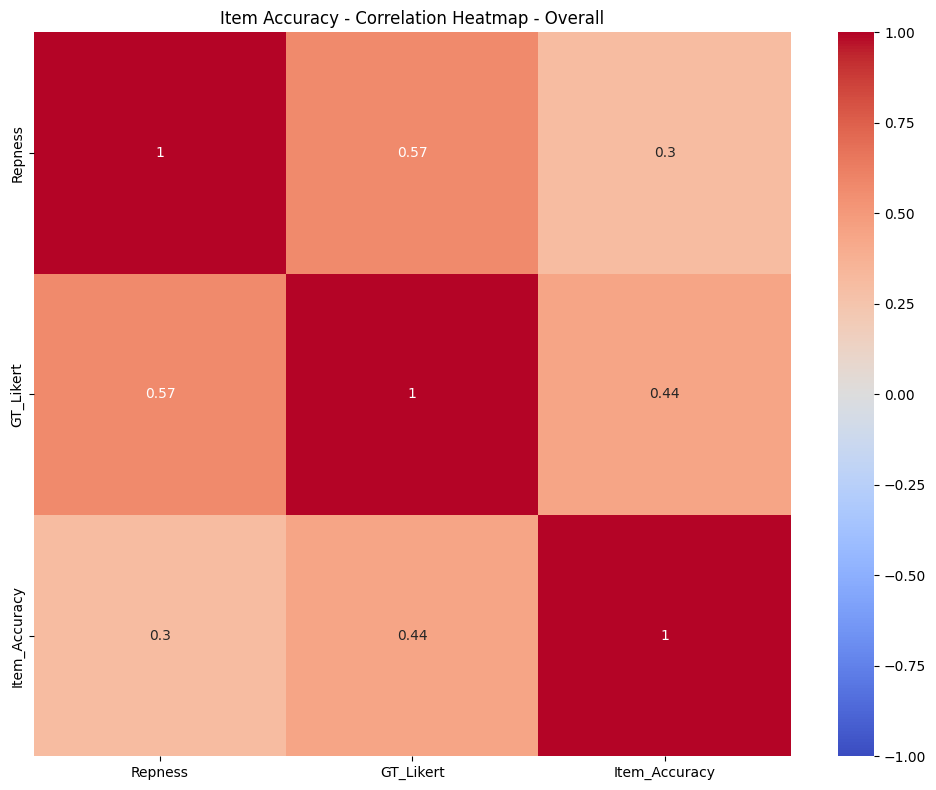


Correlation Matrix:
                Repness  GT_Likert  Item_Accuracy
Repness        1.000000   0.573629       0.304734
GT_Likert      0.573629   1.000000       0.444961
Item_Accuracy  0.304734   0.444961       1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.5736
P-value: 0.0000

Repness vs Item_Accuracy:
Spearman Correlation: 0.3047
P-value: 0.0000

GT_Likert vs Item_Accuracy:
Spearman Correlation: 0.4450
P-value: 0.0000


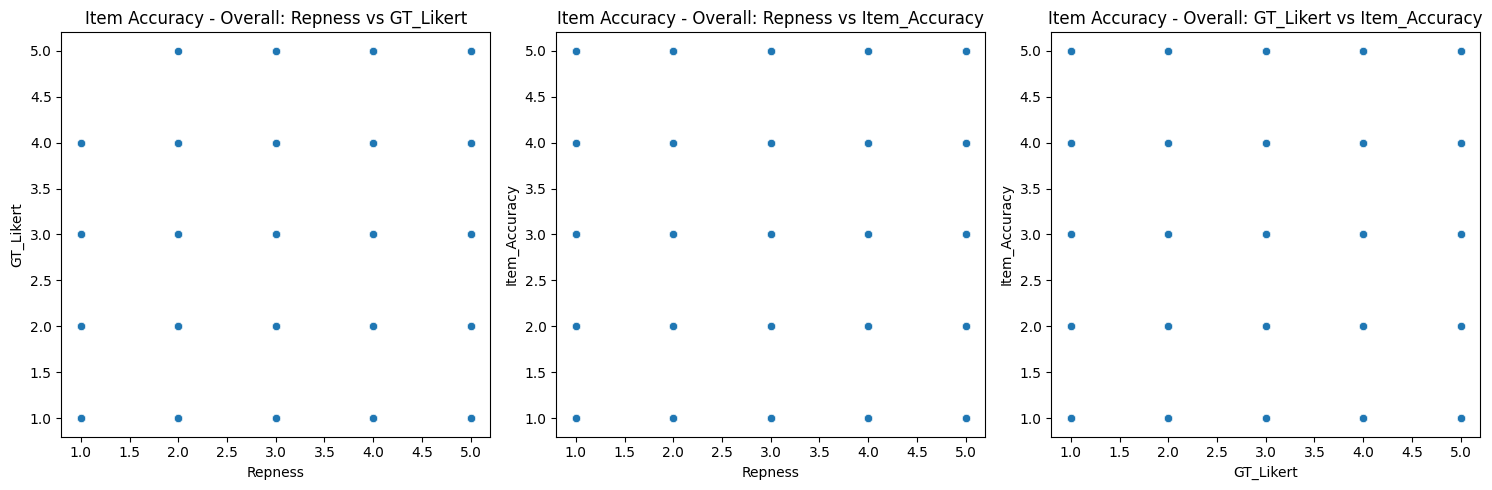


=== Item Accuracy - Global North Analysis ===
Total Items: 194


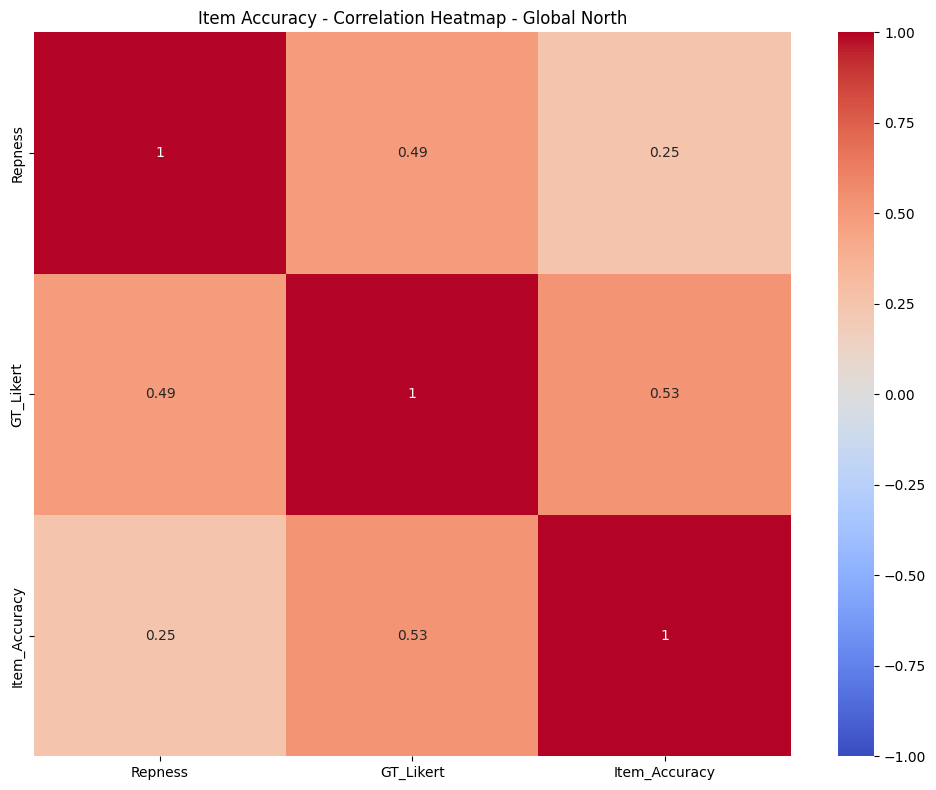


Correlation Matrix:
                Repness  GT_Likert  Item_Accuracy
Repness        1.000000   0.486087       0.250881
GT_Likert      0.486087   1.000000       0.526759
Item_Accuracy  0.250881   0.526759       1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.4861
P-value: 0.0000

Repness vs Item_Accuracy:
Spearman Correlation: 0.2509
P-value: 0.0004

GT_Likert vs Item_Accuracy:
Spearman Correlation: 0.5268
P-value: 0.0000


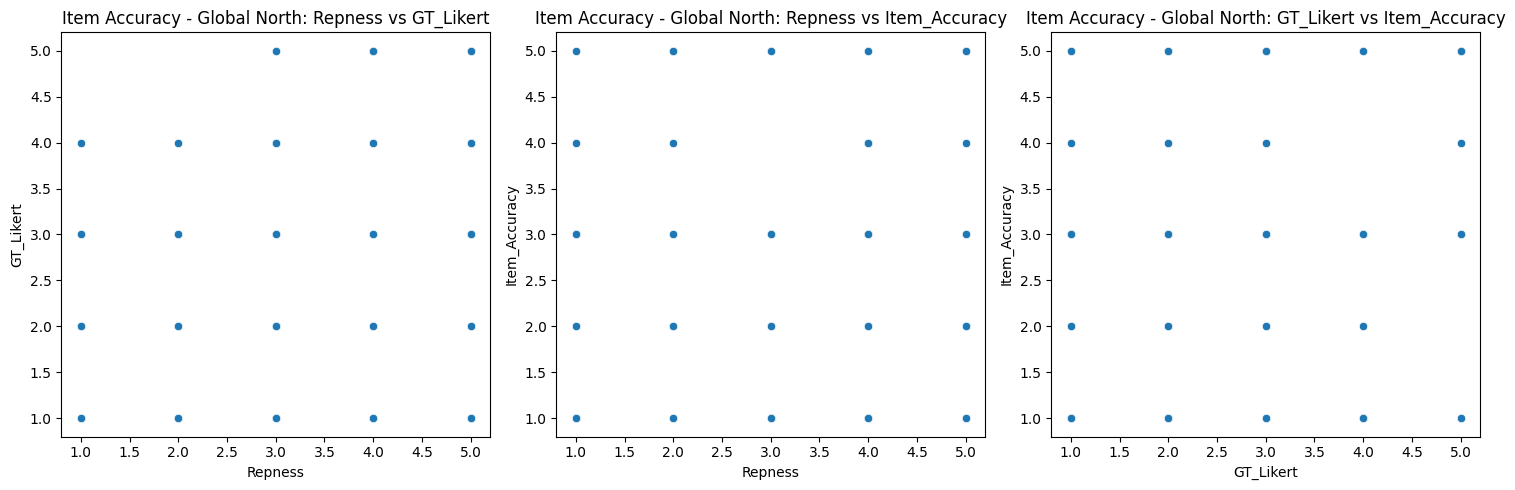


=== Item Accuracy - Global South Analysis ===
Total Items: 288


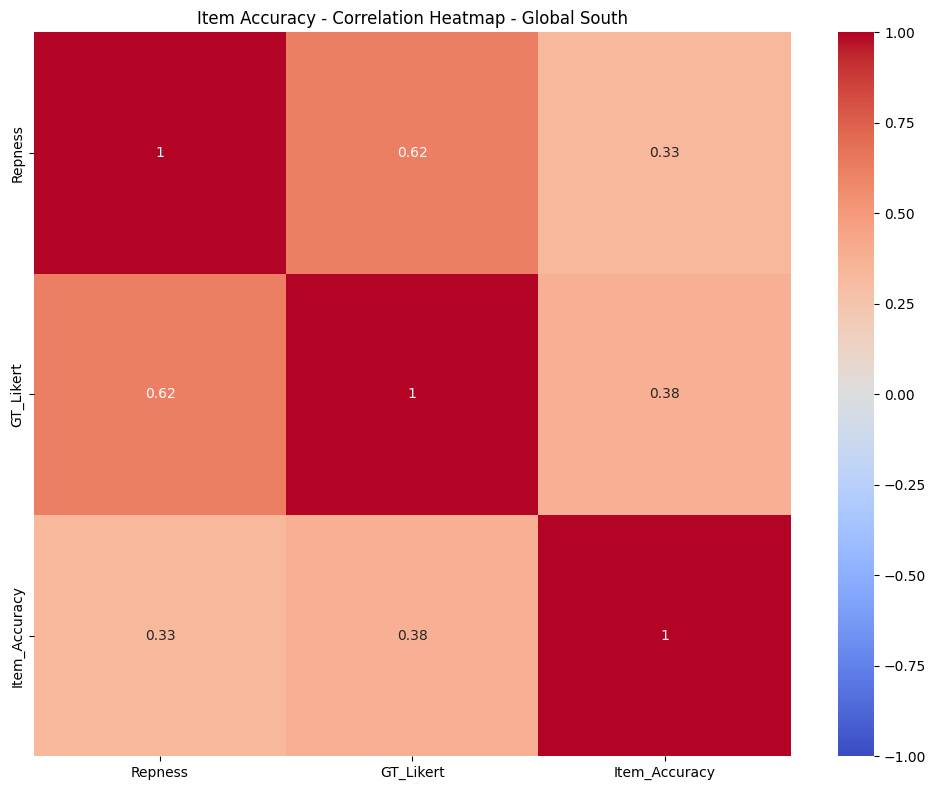


Correlation Matrix:
                Repness  GT_Likert  Item_Accuracy
Repness        1.000000   0.620122       0.331083
GT_Likert      0.620122   1.000000       0.380586
Item_Accuracy  0.331083   0.380586       1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.6201
P-value: 0.0000

Repness vs Item_Accuracy:
Spearman Correlation: 0.3311
P-value: 0.0000

GT_Likert vs Item_Accuracy:
Spearman Correlation: 0.3806
P-value: 0.0000


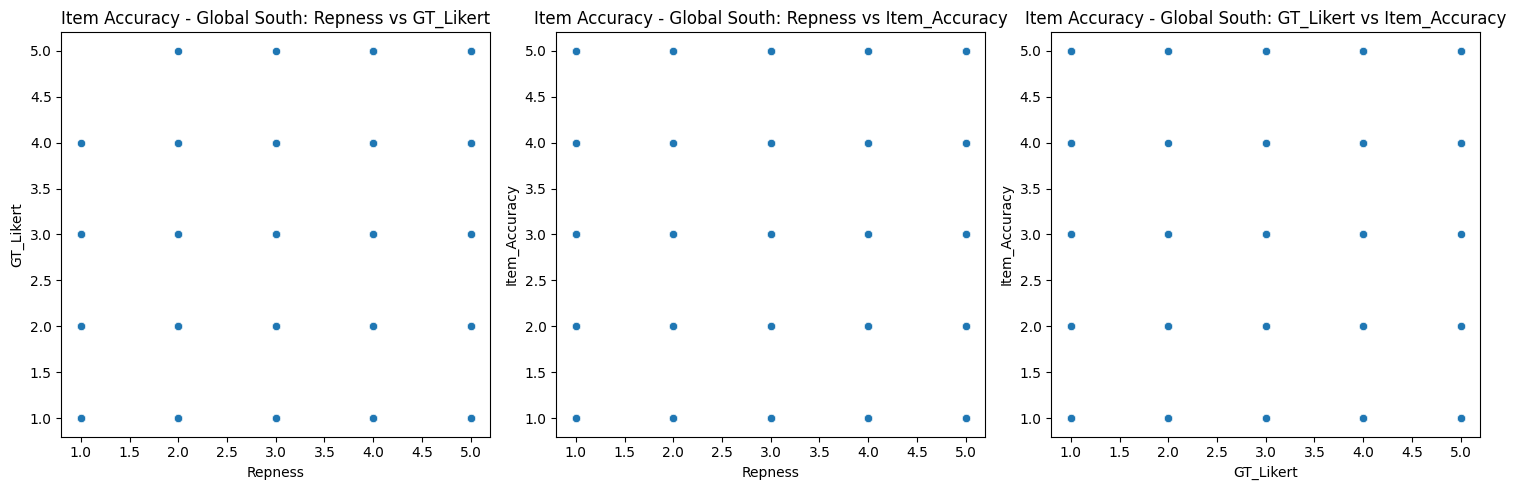


RUNNING COUNTRY LIKELIHOOD ANALYSIS
Checking file paths:
Post-study CSV: /home/mahesh/git1/gerafe/user_study/post-study-combined_surveys-flux.csv
  Exists: True
Survey JSON: /home/mahesh/user_study_img_exp/results_flux_gemini-2.5-flash/output-all-with-gemini-2.5-flash-q3-responses-FINAL.json
  Exists: True
Loaded 920 items from post-study CSV
Processing 300 items from survey data...
Extracted 156 blind ratings for Country Likelihood

=== Country Likelihood - Overall Analysis ===
Total Items: 482


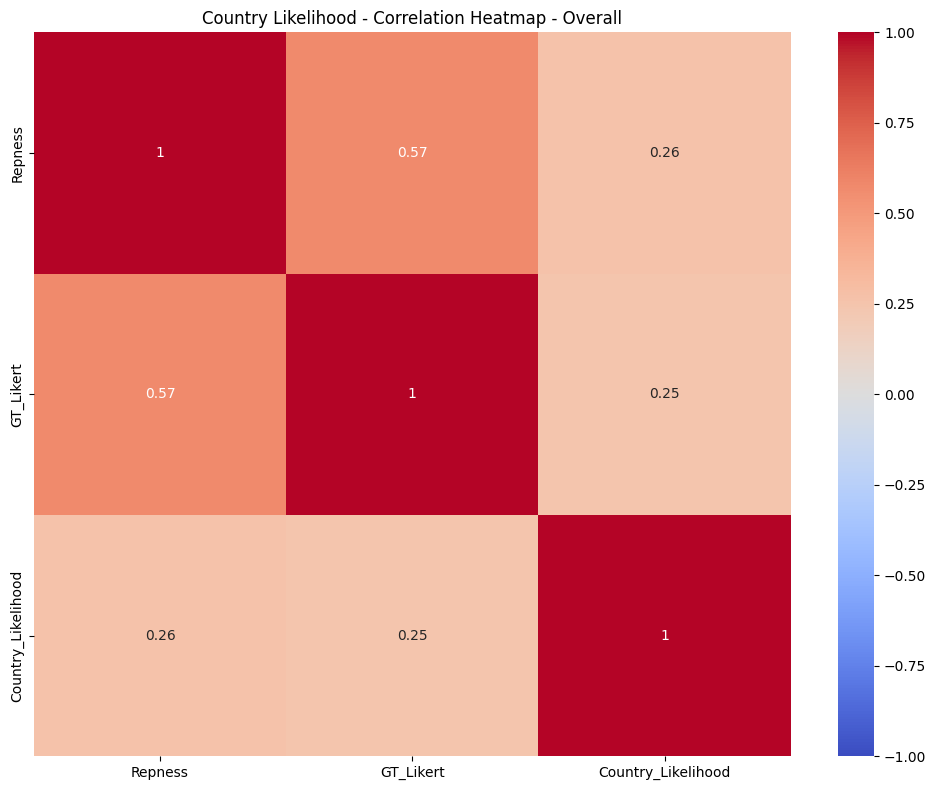


Correlation Matrix:
                     Repness  GT_Likert  Country_Likelihood
Repness             1.000000   0.573629            0.260378
GT_Likert           0.573629   1.000000            0.246269
Country_Likelihood  0.260378   0.246269            1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.5736
P-value: 0.0000

Repness vs Country_Likelihood:
Spearman Correlation: 0.2604
P-value: 0.0000

GT_Likert vs Country_Likelihood:
Spearman Correlation: 0.2463
P-value: 0.0000


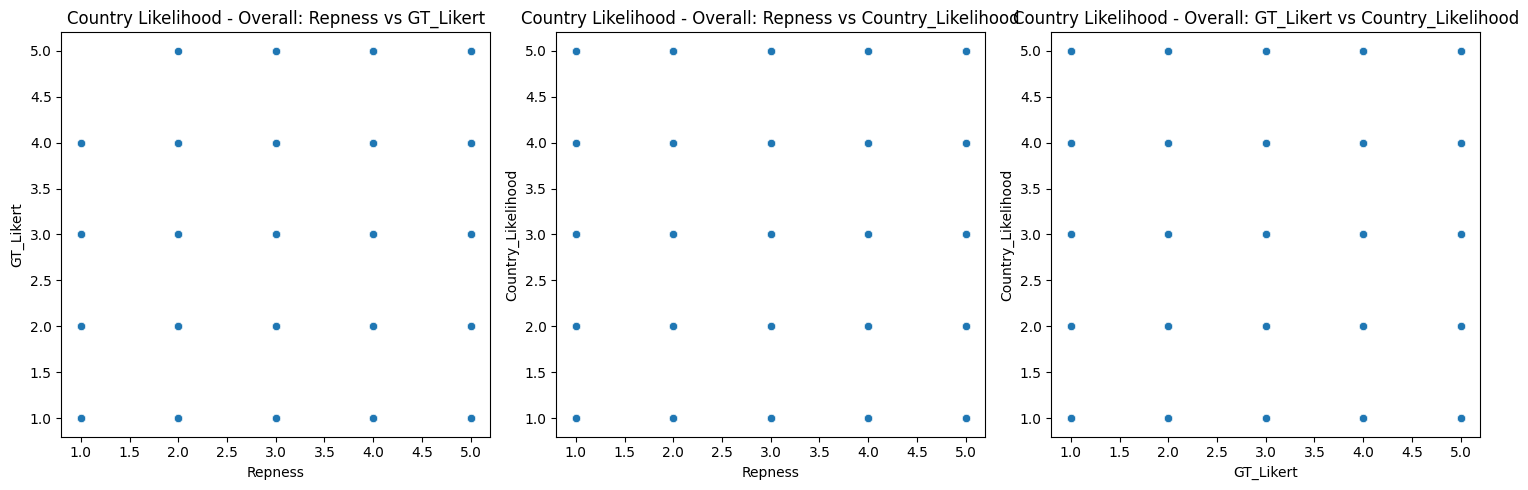


=== Country Likelihood - Global North Analysis ===
Total Items: 194


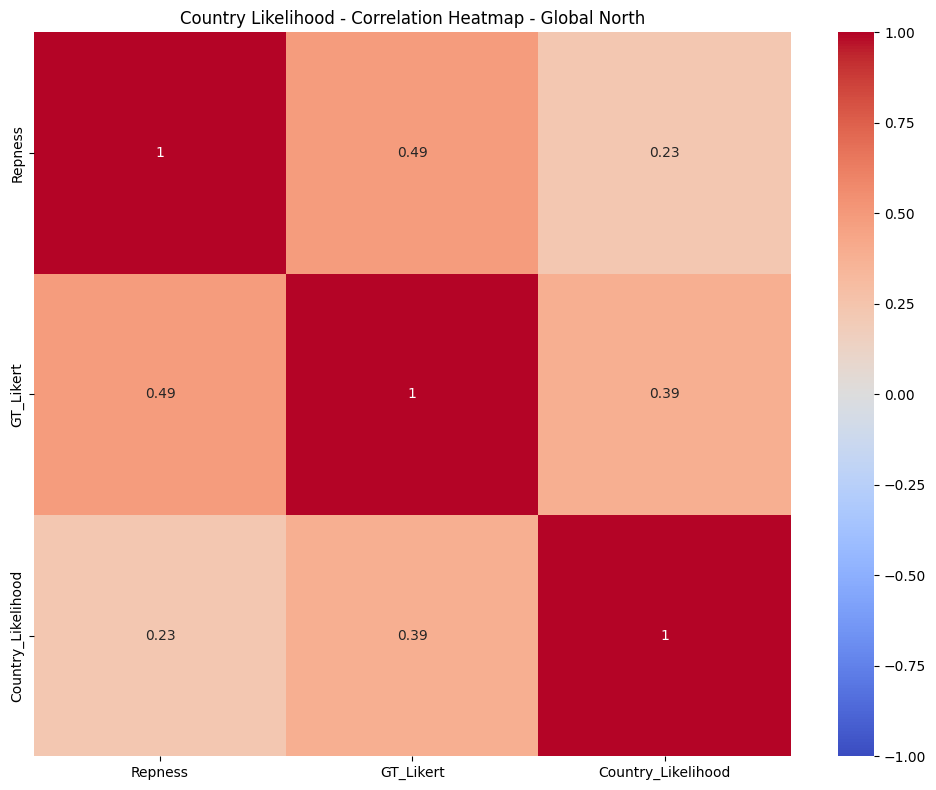


Correlation Matrix:
                     Repness  GT_Likert  Country_Likelihood
Repness             1.000000   0.486087            0.233675
GT_Likert           0.486087   1.000000            0.387654
Country_Likelihood  0.233675   0.387654            1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.4861
P-value: 0.0000

Repness vs Country_Likelihood:
Spearman Correlation: 0.2337
P-value: 0.0010

GT_Likert vs Country_Likelihood:
Spearman Correlation: 0.3877
P-value: 0.0000


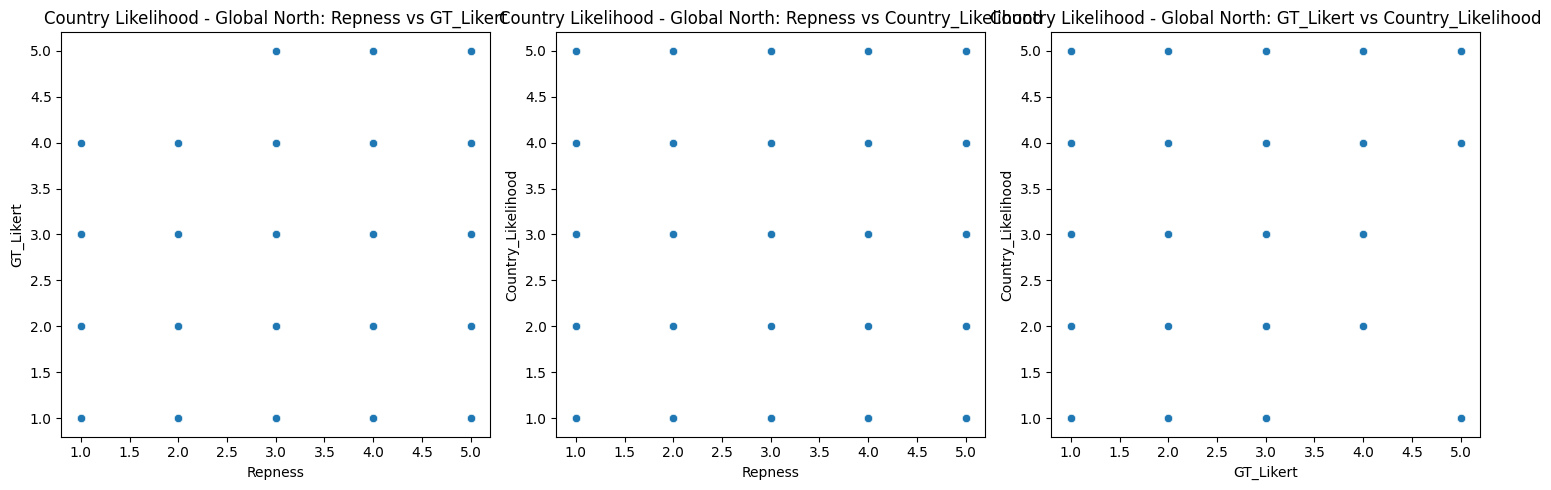


=== Country Likelihood - Global South Analysis ===
Total Items: 288


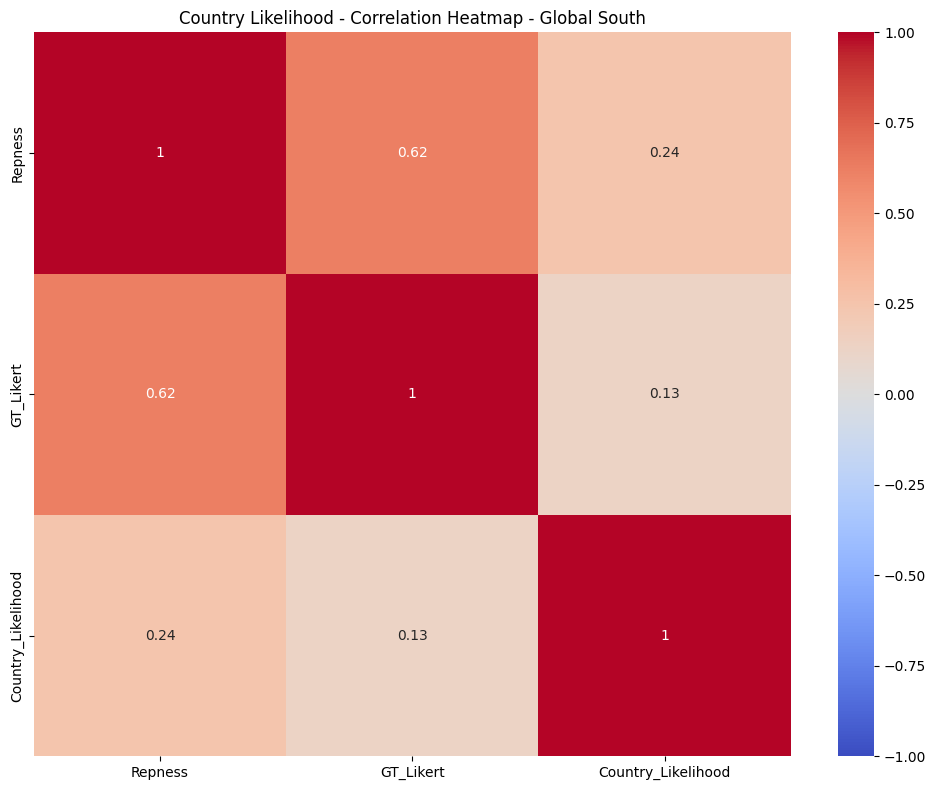


Correlation Matrix:
                     Repness  GT_Likert  Country_Likelihood
Repness             1.000000   0.620122            0.244666
GT_Likert           0.620122   1.000000            0.130758
Country_Likelihood  0.244666   0.130758            1.000000

Statistical Tests:

Repness vs GT_Likert:
Spearman Correlation: 0.6201
P-value: 0.0000

Repness vs Country_Likelihood:
Spearman Correlation: 0.2447
P-value: 0.0000

GT_Likert vs Country_Likelihood:
Spearman Correlation: 0.1308
P-value: 0.0265


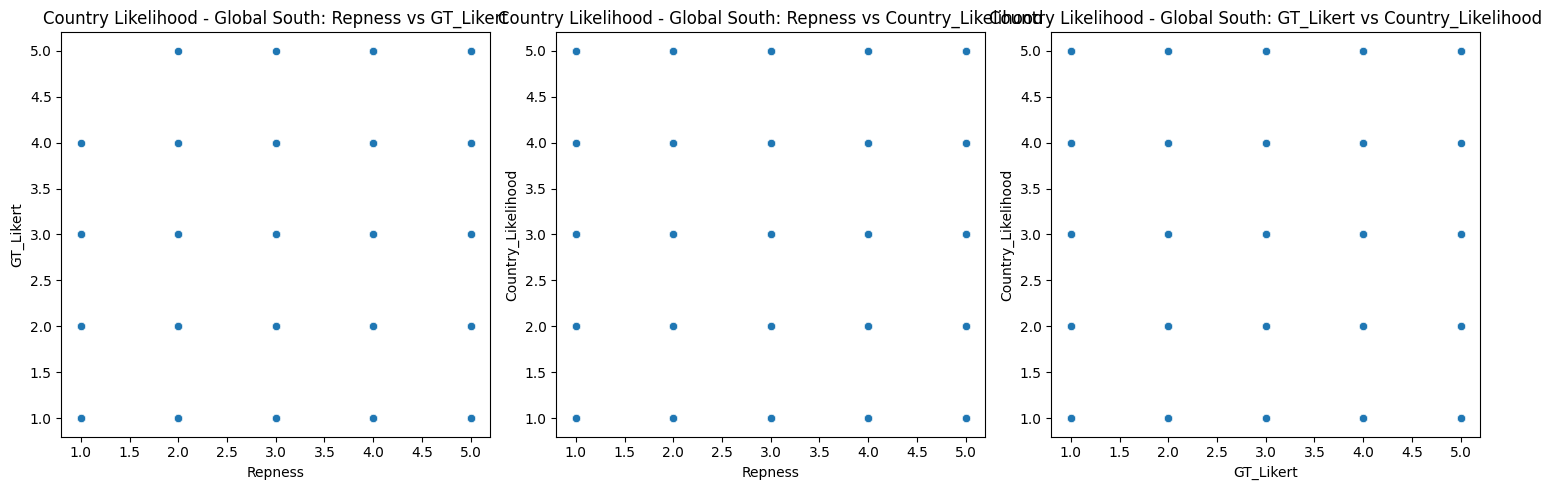

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

def run_all_correlation_analyses(model_name, api_model_name='gemini-2.5-flash'):
    """
    Run all three correlation analyses for a given model
    
    Parameters:
    model_name (str): Name of the model ('sd15', 'sd35', 'flux', etc.)
    api_model_name (str): Name of the API model (e.g., 'gemini-2.5-flash'')
    """
    
    # Define file paths
    post_study_csv_path = f'/home/mahesh/git1/gerafe/user_study/post-study-combined_surveys-{model_name}.csv'
    q3_survey_json_path = f'/home/mahesh/user_study_img_exp/results_{model_name}_{api_model_name}/output-all-with-{api_model_name}-q3-responses-FINAL.json'
    similarity_survey_json_path = f'/home/mahesh/user_study_img_exp/results_{model_name}_{api_model_name}/output-{model_name}-with-{api_model_name}-similarity-rating-FINAL.json'
    wikibias_data_path = [
        '../prepare_data/wikibias_csv/architecture.csv',
        '../prepare_data/wikibias_csv/art.csv',
        '../prepare_data/wikibias_csv/celebrations.csv',
        '../prepare_data/wikibias_csv/fashion.csv',
        '../prepare_data/wikibias_csv/food.csv',
        '../prepare_data/wikibias_csv/people.csv'
    ]
    
    def load_wikibias_data(file_paths):
        merged_df = pd.DataFrame()
        for file in file_paths:
            temp_df = pd.read_csv(file)
            temp_df['Item'] = temp_df['Item'].str.replace(' ', '_')
            temp_df = temp_df[["Item", "Global North/South"]]
            merged_df = pd.concat([merged_df, temp_df])
        return merged_df

    def perform_correlation_analysis(data, analysis_columns, column_labels, title, analysis_type):
        """
        Perform correlation analysis on a given dataset
        """
        # Drop rows with NaN values
        corr_df = data[analysis_columns].dropna()
        
        # Rename columns for clarity
        corr_df.columns = column_labels
        
        print(f"\n=== {analysis_type} - {title} Analysis ===")
        print(f"Total Items: {len(corr_df)}")
        
        # Compute Spearman correlation matrix
        corr_matrix = corr_df.corr(method='spearman')
        
        # Create correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
        plt.title(f'{analysis_type} - Correlation Heatmap - {title}')
        plt.tight_layout()
        plt.show()
        
        # Print correlation matrix
        print("\nCorrelation Matrix:")
        print(corr_matrix)
        
        # Perform statistical tests
        print("\nStatistical Tests:")
        for i in range(len(column_labels)):
            for j in range(i+1, len(column_labels)):
                col1, col2 = column_labels[i], column_labels[j]
                try:
                    corr, p_value = stats.spearmanr(corr_df[col1], corr_df[col2])
                    print(f"\n{col1} vs {col2}:")
                    print(f"Spearman Correlation: {corr:.4f}")
                    print(f"P-value: {p_value:.4f}")
                except Exception as e:
                    print(f"Error computing correlation for {col1} vs {col2}: {e}")
        
        # Scatter plots
        plt.figure(figsize=(15, 5))
        
        # Plot 1
        plt.subplot(1, 3, 1)
        sns.scatterplot(data=corr_df, x=column_labels[0], y=column_labels[1])
        plt.title(f'{analysis_type} - {title}: {column_labels[0]} vs {column_labels[1]}')
        
        # Plot 2
        plt.subplot(1, 3, 2)
        sns.scatterplot(data=corr_df, x=column_labels[0], y=column_labels[2])
        plt.title(f'{analysis_type} - {title}: {column_labels[0]} vs {column_labels[2]}')
        
        # Plot 3
        plt.subplot(1, 3, 3)
        sns.scatterplot(data=corr_df, x=column_labels[1], y=column_labels[2])
        plt.title(f'{analysis_type} - {title}: {column_labels[1]} vs {column_labels[2]}')
        
        plt.tight_layout()
        plt.show()

    def run_single_analysis(rating_key, rating_source, analysis_columns, column_labels, analysis_type):
        """
        Run a single correlation analysis
        """
        print(f"\n{'='*60}")
        print(f"RUNNING {analysis_type.upper()} ANALYSIS")
        print(f"{'='*60}")
        
        # Determine which JSON file to use
        if analysis_type == 'Similarity Rating':
            survey_json_path = similarity_survey_json_path
        else:
            survey_json_path = q3_survey_json_path
        
        # Check if files exist
        import os
        print(f"Checking file paths:")
        print(f"Post-study CSV: {post_study_csv_path}")
        print(f"  Exists: {os.path.exists(post_study_csv_path)}")
        print(f"Survey JSON: {survey_json_path}")
        print(f"  Exists: {os.path.exists(survey_json_path)}")
        
        # Load post-study data
        post_study_df = pd.read_csv(post_study_csv_path)
        post_study_df['item'] = post_study_df['Item'].str.replace(' ', '_')
        print(f"Loaded {len(post_study_df)} items from post-study CSV")
        
        # Load survey data
        with open(survey_json_path, 'r') as f:
            survey_data = json.load(f)
        
        # Extract blind ratings
        blind_ratings = []
        print(f"Processing {len(survey_data)} items from survey data...")
        
        for item, responses in survey_data.items():
            for response in responses:
                try:
                    if rating_source == 'gemini_responses':
                        if 'gemini_responses' in response and rating_key in response['gemini_responses']:
                            blind_ratings.append({
                                'item': item,
                                'blind_rating': response['gemini_responses'][rating_key]
                            })
                    else:
                        if rating_key in response:
                            blind_ratings.append({
                                'item': item,
                                'blind_rating': response[rating_key]
                            })
                except Exception as e:
                    print(f"Warning: Error processing item {item}: {e}")
        
        print(f"Extracted {len(blind_ratings)} blind ratings for {analysis_type}")
        
        if len(blind_ratings) == 0:
            print(f"ERROR: No blind ratings found for {analysis_type}")
            print(f"Rating key: {rating_key}, Rating source: {rating_source}")
            # Let's examine the structure of the first few items
            for item, responses in list(survey_data.items())[:2]:
                print(f"Sample item '{item}' structure:")
                for i, response in enumerate(responses[:1]):
                    print(f"  Response {i} keys: {response.keys()}")
                    if 'gemini_responses' in response:
                        print(f"  Gemini responses keys: {response['gemini_responses'].keys()}")
            return
        
        blind_df = pd.DataFrame(blind_ratings)
        
        # Merge dataframes
        merged_df = pd.merge(post_study_df, blind_df, on='item', how='inner')
        
        # Convert columns to numeric
        for col in analysis_columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        
        # Load and merge WikiBias data
        wikibias_df = load_wikibias_data(wikibias_data_path)
        merged_df = pd.merge(merged_df, wikibias_df[['Item', 'Global North/South']], 
                             left_on='item', right_on='Item', how='left')
        
        # Perform analysis for different datasets
        perform_correlation_analysis(merged_df, analysis_columns, column_labels, "Overall", analysis_type)
        
        # Global North
        global_north_df = merged_df[merged_df['Global North/South'] == 'Global North']
        perform_correlation_analysis(global_north_df, analysis_columns, column_labels, "Global North", analysis_type)
        
        # Global South
        global_south_df = merged_df[merged_df['Global North/South'] == 'Global South']
        perform_correlation_analysis(global_south_df, analysis_columns, column_labels, "Global South", analysis_type)

    # Run all three analyses
    print(f"Running correlation analyses for model: {model_name}")
    
    # Analysis 1: Item Accuracy
    run_single_analysis(
        rating_key='Q3_item_accuracy',
        rating_source='gemini_responses',
        analysis_columns=['cult_repness_likert', 'gt_likelihood_likert', 'blind_rating'],
        column_labels=['Repness', 'GT_Likert', 'Item_Accuracy'],
        analysis_type='Item Accuracy'
    )
    
    # Analysis 2: Country Likelihood  
    run_single_analysis(
        rating_key='Q3_country_likelihood',
        rating_source='gemini_responses',
        analysis_columns=['cult_repness_likert', 'gt_likelihood_likert', 'blind_rating'],
        column_labels=['Repness', 'GT_Likert', 'Country_Likelihood'],
        analysis_type='Country Likelihood'
    )
    
    # Analysis 3: Similarity Rating
    # run_single_analysis(
    #     rating_key='gemini_similarity_rating',
    #     rating_source='direct',
    #     analysis_columns=['cult_repness_likert', 'percep_sim_likert', 'blind_rating'],
    #     column_labels=['Repness', 'Percep_Sim', 'Similarity_Rating'],
    #     analysis_type='Similarity Rating'
    # )

# Usage: Just change the model name and API model name and run
model_name = 'flux'  # Change this to 'sd35', 'flux', etc.
api_model_name = 'gemini-2.5-flash'  # Change this to your API model name
run_all_correlation_analyses(model_name, api_model_name)

In [ ]:
#!/usr/bin/env python3
# Verify a HF dataset has proper Image() columns and real image bytes.

import os, sys, warnings
warnings.filterwarnings("ignore")
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

from typing import Tuple, List
from datasets import load_dataset, Image

REPO_ID = "Mahesh111000/cultural-bias-image-survey"
SPLIT   = "train"       # change if you added more splits
SAMPLE  = 10            # how many rows to probe for bytes

def check_image_col(ds, col: str) -> Tuple[int, int, List[str]]:
    """
    Returns (non_null_rows, ok_bytes_rows, bad_paths_preview)
    """
    if col not in ds.column_names:
        return (0, 0, [f"Column '{col}' not found."])
    non_null = 0
    ok_bytes = 0
    bad_paths = []
    # probe up to SAMPLE rows across the dataset (spaced out)
    n = len(ds)
    idxs = list(range(min(SAMPLE, n)))
    # if big, spread the probes
    if n > SAMPLE:
        step = max(n // SAMPLE, 1)
        idxs = [i*step for i in range(SAMPLE)]
    for i in idxs:
        cell = ds[i][col]
        if cell is None:
            continue
        non_null += 1
        # Expect dict like: {"path": "...", "bytes": b"..."}
        path = cell.get("path") if isinstance(cell, dict) else None
        b    = cell.get("bytes") if isinstance(cell, dict) else None
        if b is not None and isinstance(b, (bytes, bytearray)) and len(b) > 0:
            ok_bytes += 1
        else:
            bad_paths.append(str(path))
    return (non_null, ok_bytes, bad_paths[:5])

def main() -> int:
    try:
        ds = load_dataset(REPO_ID, split=SPLIT)
    except Exception as e:
        print(f"FAIL could not load dataset: {e}")
        return 1

    # Basic info
    print(f"Loaded: {REPO_ID} [{SPLIT}]")
    print(f"Rows: {len(ds)}")

    # Feature checks
    feats = ds.features
    print("Features:")
    for k, v in feats.items():
        vname = getattr(v, "__class__", type(v)).__name__
        print(f"  - {k}: {vname}")

    # Must be Image() for thumbnails to render
    for col in ("van_image", "grid_image"):
        f = feats.get(col)
        if not isinstance(f, Image):
            print(f"FAIL column '{col}' is not Image(): got {type(f)}")
            return 1

    # Probe a few rows to ensure bytes are downloadable
    for col in ("van_image", "grid_image"):
        non_null, ok_bytes, bad = check_image_col(ds, col)
        print(f"[{col}] non-null probed: {non_null}, with-bytes: {ok_bytes}/{max(1, non_null)}")
        if bad:
            print(f"  sample missing-bytes paths (first {len(bad)}):")
            for p in bad:
                print(f"    - {p}")

    print("OK dataset loaded and image bytes check completed")
    return 0

if __name__ == "__main__":
    sys.exit(main())